In [1]:
import pandas as pd
sales_granular= pd.read_csv("C:\\Users\\OMA5396\\Documents\\my files\\PMI\\Usecase\\sales_granular.csv")

###  Aggregate sales file 

In [2]:
sales_dem = sales_granular
sales_dem['sales_sum'] = sales_dem.iloc[:,1:].sum(axis = 1, skipna = 'TRUE')

In [3]:
sales_dem = sales_dem[['store_code','sales_sum']]

In [4]:
sales_dem = sales_dem.groupby('store_code').sum(axis = 0, skipna = 'TRUE')

In [5]:
sales_dem.shape

(903, 1)

### Surrounding File

In [6]:
import json

In [7]:
with open("C:\\Users\\OMA5396\\Documents\\my files\\PMI\\Usecase\\Surroundings.json") as f:
    data = json.load(f)

In [8]:
store_cd = []
sr_name = []
sr_count = []
for j in data:
    for a, b in j['surroundings'].items():
            store_cd.append(j['store_code'])
            sr_name.append(a)
            sr_count.append(len(b))
            

In [9]:
df = pd.DataFrame()
df['store_cd'] = store_cd
df['sr_type'] = sr_name
df['sr_count'] =  sr_count

In [11]:
import numpy as np

In [12]:
df_pivot = pd.pivot_table(df, values = 'sr_count', index = 'store_cd', columns = 'sr_type', aggfunc= np.sum)

In [24]:
df_pivot.head()

sr_type,accounting,airport,amusement_park,aquarium,art_gallery,atm,bakery,bank,bar,beauty_salon,...,store,subway_station,synagogue,taxi_stand,train_station,transit_station,travel_agency,university,veterinary_care,zoo
store_cd,,,,,,,,,,,,,,,,,,,,,
282,1,0,0,0,5,9,7,11,19,21,...,60,0,0,0,0,2,13,0,0,0
425,0,0,0,0,0,0,0,0,0,0,...,12,0,0,0,0,0,0,0,0,0
1498,0,0,0,0,0,4,6,8,8,10,...,60,0,0,0,1,5,5,0,0,0
2286,2,0,0,0,5,5,6,7,3,7,...,60,2,0,0,1,5,9,1,1,0
2331,0,0,0,0,1,2,1,3,5,7,...,45,0,0,0,1,4,2,0,0,0


### Merge Sales and Surround file

In [13]:
sales_merged = pd.merge(sales_dem,df_pivot, 'inner', left_index= True , right_index=True )

In [14]:
sales_merged = sales_merged.sort_index()

In [15]:
sales_merged['sales_sum'].describe()

count    5.390000e+02
mean     2.227547e+04
std      1.051486e+05
min      0.000000e+00
25%      1.800000e+03
50%      4.980000e+03
75%      1.231500e+04
max      2.156160e+06
Name: sales_sum, dtype: float64

In [16]:
import seaborn as sns

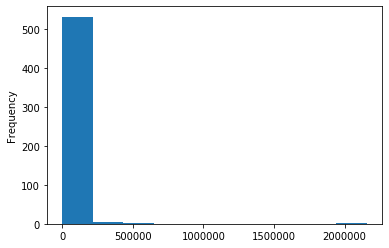

In [17]:
sales_merged['sales_sum'].plot(kind='hist') #plot without log transformation, highly skewed

### Outlier transformation

In [18]:
sales_merged["sales_sum_log"] = sales_merged["sales_sum"].map(lambda i: np.log(i) if i > 0 else 0) 

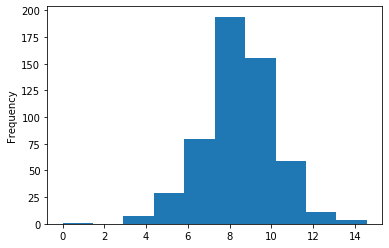

In [19]:
sales_merged['sales_sum_log'].plot(kind='hist')

### Dividing sales into quintiles

In [20]:
sales_merged_sorted = sales_merged.sort_values(by = 'sales_sum_log', ascending=True)

In [21]:
sales_merged_sorted = sales_merged_sorted[sales_merged_sorted['sales_sum_log']>0]

In [22]:
sales_merged_sorted['quintile'] = sales_merged_sorted['sales_sum_log'].cumsum()/sales_merged_sorted['sales_sum_log'].sum()*5

In [23]:
sales_merged_sorted['quintile'] = np.ceil(sales_merged_sorted['quintile']).astype('int64')

# One vs Rest Multiclass Classification

### Cross Validation with Grid Search

In [32]:
from sklearn.model_selection import train_test_split 

### train_test split

In [157]:
x = sales_merged_sorted.drop(['sales_sum','sales_sum_log','quintile','class5','class4','class3','class2','class1'], axis = 1)

In [158]:
y = sales_merged_sorted[['quintile']]

In [159]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.30,random_state=0,stratify=y)

In [46]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2000, stop = 6000, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 25, 50]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [2000, 3000, 4000, 5000, 6000], 'max_depth': [10, 35, 60, 85, 110, None], 'min_samples_leaf': [10, 25, 50], 'bootstrap': [True, False]}


In [160]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train.values.ravel())

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [161]:
print('Training Score: {:.2f} \nValidation Score: {:.2f}'.format(rf_random.score(x_train, y_train), 
                                                                                             rf_random.score(x_test, y_test)))


Training Score: 0.65 
Validation Score: 0.35


In [162]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_leaf': 10,
 'max_depth': 85,
 'bootstrap': True}

### Random Forest

In [28]:
qunit5_data = sales_merged_sorted
qunit5_data['class5'] = sales_merged_sorted['quintile'].apply(lambda i: 1 if i == 5 else 0)

#### Quintile 5

In [29]:
x5 = qunit5_data.drop(['quintile','sales_sum','sales_sum_log','class5'], axis = 1)

In [30]:
y5 = qunit5_data[['class5']]

##### Split Train and Test

In [34]:
x5_train, x5_test, y5_train, y5_test = train_test_split(x5, y5,test_size=0.30,random_state=0,stratify=y5)

In [163]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 2000,
                           n_jobs = -1,
                           min_samples_leaf = 10,
                           max_depth = 85, 
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(x5_train, y5_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=85, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [164]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(x5_train, y5_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(x5_test, y5_test)))


R^2 Training Score: 0.82 
OOB Score: 0.82 
R^2 Validation Score: 0.82


In [165]:
Imp_df  =  pd.DataFrame()
Imp_df ["Description_feature" ]  =  x5_train.columns
Imp_df ["importance"]  =  rf.feature_importances_ 
Imp_df.sort_values('importance', ascending=False, inplace=True)
Imp_df = Imp_df[0:10]
Imp_df.sort_values('importance', ascending=True, inplace=True)

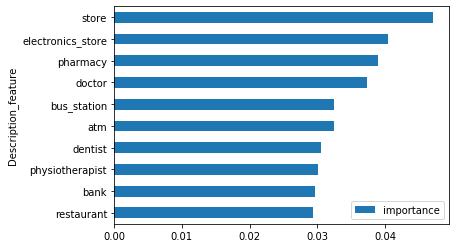

In [166]:
import matplotlib.pyplot as plt
Imp_df.plot(kind = 'barh', y = 'importance' , x = 'Description_feature')

#### Qunitile 4

In [87]:
qunit4_data = sales_merged_sorted
qunit4_data['class4'] = sales_merged_sorted['quintile'].apply(lambda i: 1 if i == 4 else 0)

In [88]:
x4 = qunit4_data.drop(['quintile','sales_sum','sales_sum_log','class4','class5'], axis = 1)

In [89]:
y4 = qunit4_data[['class4']]

##### Split Train and Test

In [92]:
x4_train, x4_test, y4_train, y4_test = train_test_split(x4, y4,test_size=0.30,random_state=0,stratify=y4)

In [167]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 2000,
                           n_jobs = -1,
                           min_samples_leaf = 10,
                           max_depth = 85, 
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(x4_train, y4_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=85, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [168]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(x4_train, y4_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(x4_test, y4_test)))


R^2 Training Score: 0.82 
OOB Score: 0.82 
R^2 Validation Score: 0.82


In [169]:
Imp_df  =  pd.DataFrame()
Imp_df ["Description_feature" ]  =  x4_train.columns
Imp_df ["importance"]  =  rf.feature_importances_ 
Imp_df.sort_values('importance', ascending=False, inplace=True)
Imp_df = Imp_df[0:10]
Imp_df.sort_values('importance', ascending=True, inplace=True)

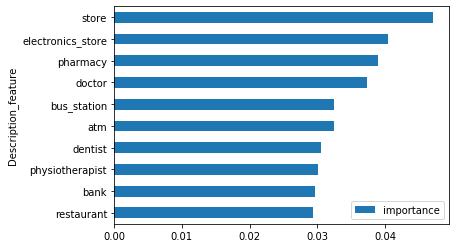

In [170]:
import matplotlib.pyplot as plt
Imp_df.plot(kind = 'barh', y = 'importance' , x = 'Description_feature')

#### Qunitile 3

In [98]:
qunit3_data = sales_merged_sorted
qunit3_data['class3'] = sales_merged_sorted['quintile'].apply(lambda i: 1 if i == 3 else 0)

In [107]:
x3 = qunit3_data.drop(['quintile','sales_sum','sales_sum_log','class4','class5','class3'], axis = 1)

In [108]:
y3 = qunit3_data[['class3']]

##### Split Train and Test

In [110]:
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3,test_size=0.30,random_state=0,stratify=y3)

In [171]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 2000,
                           n_jobs = -1,
                           min_samples_leaf = 10,
                           max_depth = 85, 
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(x3_train, y3_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=85, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [172]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(x3_train, y3_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(x3_test, y3_test)))


R^2 Training Score: 0.81 
OOB Score: 0.81 
R^2 Validation Score: 0.81


In [173]:
Imp_df  =  pd.DataFrame()
Imp_df ["Description_feature" ]  =  x3_train.columns
Imp_df ["importance"]  =  rf.feature_importances_ 
Imp_df.sort_values('importance', ascending=False, inplace=True)
Imp_df = Imp_df[0:10]
Imp_df.sort_values('importance', ascending=True, inplace=True)

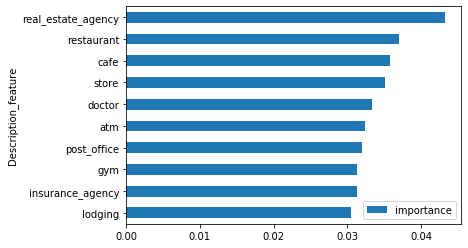

In [174]:
import matplotlib.pyplot as plt
Imp_df.plot(kind = 'barh', y = 'importance' , x = 'Description_feature')

#### Qunitile 2

In [132]:
qunit2_data = sales_merged_sorted
qunit2_data['class2'] = sales_merged_sorted['quintile'].apply(lambda i: 1 if i == 2 else 0)

In [133]:
x2 = qunit2_data.drop(['quintile','sales_sum','sales_sum_log','class4','class5','class3','class2',], axis = 1)

In [134]:
y2 = qunit2_data[['class2']]

##### Split Train and Test

In [135]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2,test_size=0.30,random_state=0,stratify=y2)

In [175]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 2000,
                           n_jobs = -1,
                           min_samples_leaf = 10,
                           max_depth = 85, 
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(x2_train, y2_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=85, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [176]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(x2_train, y2_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(x2_test, y2_test)))


R^2 Training Score: 0.79 
OOB Score: 0.79 
R^2 Validation Score: 0.79


In [177]:
Imp_df  =  pd.DataFrame()
Imp_df ["Description_feature" ]  =  x2_train.columns
Imp_df ["importance"]  =  rf.feature_importances_ 
Imp_df.sort_values('importance', ascending=False, inplace=True)
Imp_df = Imp_df[0:10]
Imp_df.sort_values('importance', ascending=True, inplace=True)

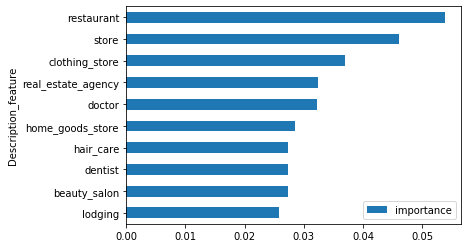

In [178]:
import matplotlib.pyplot as plt
Imp_df.plot(kind = 'barh', y = 'importance' , x = 'Description_feature')

#### Qunitile 1

In [140]:
qunit1_data = sales_merged_sorted
qunit1_data['class1'] = sales_merged_sorted['quintile'].apply(lambda i: 1 if i == 1 else 0)

In [141]:
x1 = qunit1_data.drop(['quintile','sales_sum','sales_sum_log','class4','class5','class3','class2','class1'], axis = 1)

In [142]:
y1 = qunit1_data[['class1']]

##### Split Train and Test

In [143]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1,test_size=0.30,random_state=0,stratify=y1)

In [179]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 2000,
                           n_jobs = -1,
                           min_samples_leaf = 10,
                           max_depth = 85, 
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(x1_train, y1_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=85, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [180]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(x1_train, y1_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(x1_test, y1_test)))


R^2 Training Score: 0.75 
OOB Score: 0.74 
R^2 Validation Score: 0.73


In [181]:
Imp_df  =  pd.DataFrame()
Imp_df ["Description_feature" ]  =  x1_train.columns
Imp_df ["importance"]  =  rf.feature_importances_ 
Imp_df.sort_values('importance', ascending=False, inplace=True)
Imp_df = Imp_df[0:10]
Imp_df.sort_values('importance', ascending=True, inplace=True)

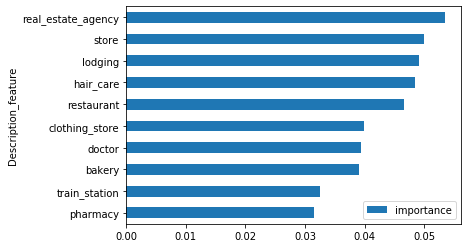

In [182]:
import matplotlib.pyplot as plt
Imp_df.plot(kind = 'barh', y = 'importance' , x = 'Description_feature')